# Example: Basic Run

In this example, we will setup a simple parcel model simulation containing two aerosol modes. We will then run the model with a 1 m/s updraft, and observe how the aerosol population bifurcates into swelled aerosol and cloud droplets.

In [2]:
# Suppress warnings
import warnings 
warnings.simplefilter('ignore')

import pyrcel as pm
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

First, we indicate the parcel's initial thermodynamic conditions.

In [3]:
P0 = 77500. # Pressure, Pa
T0 = 274.   # Temperature, K
S0 = -0.02  # Supersaturation, 1-RH (98% here)

Next, we define the aerosols present in the parcel. The model itself is agnostic to how the aerosol are specified; it simply expects lists of the radii of wetted aerosol radii, their number concentration, and their hygroscopicity. We can make container objects (:class:`AerosolSpecies`) that wrap all of this information so that we never need to worry about it.

Here, let's construct two aerosol modes:

+----------+---------------------------+--------------------+---------+------------------------+
| Mode     | $\kappa$ (hygroscopicity) | Mean size (micron) | Std dev | Number Conc (cm\*\*-3) |
+==========+===========================+====================+=========+========================+
| sulfate  | 0.54                      | 0.015              | 1.6     | 850                    |
+----------+---------------------------+--------------------+---------+------------------------+
| sea salt | 1.2                       | 0.85               | 1.2     | 10                     |
+----------+---------------------------+--------------------+---------+------------------------+

We'll define each mode using the :class:`Lognorm` distribution packaged with the model.

In [9]:
sulfate =  pm.AerosolSpecies('sulfate', 
                             pm.Lognorm(mu=0.015, sigma=1.6, N=200.),
                             kappa=0.54, bins=200)
sea_salt = pm.AerosolSpecies('sea salt',
                             pm.Lognorm(mu=0.85, sigma=1.2, N=10.),
                             kappa=1.2, bins=40)

The :class:`AerosolSpecies` class automatically computes gridded/binned representations of the size distributions. Let's double check that the aerosol distribution in the model will make sense by plotting the number concentration in each bin.

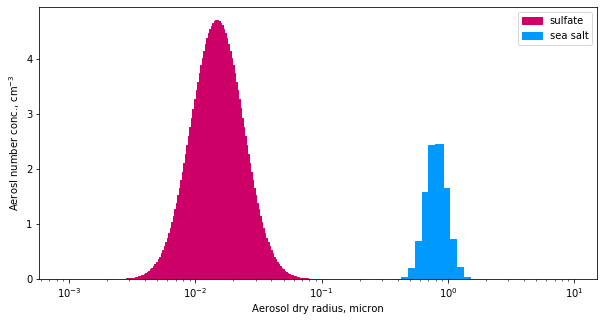

In [10]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.grid(False, "minor")

sul_c = "#CC0066"
ax.bar(sulfate.rs[:-1], sulfate.Nis*1e-6, np.diff(sulfate.rs),
        color=sul_c, label="sulfate", edgecolor="#CC0066")
sea_c = "#0099FF"
ax.bar(sea_salt.rs[:-1], sea_salt.Nis*1e-6, np.diff(sea_salt.rs),
        color=sea_c, label="sea salt", edgecolor="#0099FF")
ax.semilogx()

ax.set_xlabel("Aerosol dry radius, micron")
ax.set_ylabel("Aerosl number conc., cm$^{-3}$")
ax.legend(loc='upper right')

Actually running the model is very straightforward, and involves just two steps:

1. Instantiate the model by creating a :class:`ParcelModel` object.
2. Call the model's :method:`run` method.

For convenience this process is encoded into several routines in the `driver` file, including both a single-strategy routine and an iterating routine which adjusts the the timestep and numerical tolerances if the model crashes. However, we can illustrate the simple model running process here in case you wish to develop your own scheme for running the model.

In [11]:
initial_aerosols = [sulfate, sea_salt]
V = 1.0 # updraft speed, m/s

dt = 1.0 # timestep, seconds
t_end = 250./V # end time, seconds... 250 meter simulation 

model = pm.ParcelModel(initial_aerosols, V, T0, S0, P0, console=False, accom=0.3)
parcel_trace, aerosol_traces = model.run(t_end, dt, solver='cvode')

If `console` is set to `True`, then some basic debugging output will be written to the terminal, including the initial equilibrium droplet size distribution and some numerical solver diagnostics. The model output can be customized; by default, we get a DataFrame and a Panel of the parcel state vector and aerosol bin sizes as a function of time (and height). We can use this to visualize the simulation results, like in the package's [README](https://github.com/darothen/parcel_model/blob/master/README.md).

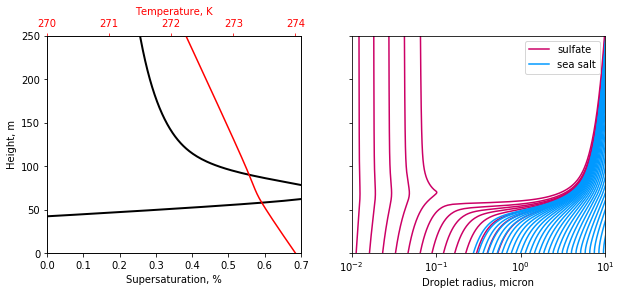

In [12]:
fig, [axS, axA] = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axS.plot(parcel_trace['S']*100., parcel_trace['z'], color='k', lw=2)
axT = axS.twiny()
axT.plot(parcel_trace['T'], parcel_trace['z'], color='r', lw=1.5)

Smax = parcel_trace['S'].max()*100
z_at_smax = parcel_trace['z'].ix[parcel_trace['S'].argmax()]
axS.annotate("max S = %0.2f%%" % Smax, 
             xy=(Smax, z_at_smax), 
             xytext=(Smax-0.3, z_at_smax+50.),
             arrowprops=dict(arrowstyle="->", color='k',
                             connectionstyle='angle3,angleA=0,angleB=90'),
             zorder=10)

axS.set_xlim(0, 0.7)
axS.set_ylim(0, 250)

axT.set_xticks([270, 271, 272, 273, 274])
axT.xaxis.label.set_color('red')
axT.tick_params(axis='x', colors='red')

axS.set_xlabel("Supersaturation, %")
axT.set_xlabel("Temperature, K")
axS.set_ylabel("Height, m")

sulf_array = aerosol_traces['sulfate'].values
sea_array = aerosol_traces['sea salt'].values

ss = axA.plot(sulf_array[:, ::10]*1e6, parcel_trace['z'], color=sul_c, 
         label="sulfate")
sa = axA.plot(sea_array*1e6, parcel_trace['z'], color=sea_c, label="sea salt")
axA.semilogx()
axA.set_xlim(1e-2, 10.)
axA.set_xticks([1e-2, 1e-1, 1e0, 1e1], [0.01, 0.1, 1.0, 10.0])
axA.legend([ss[0], sa[0]], ['sulfate', 'sea salt'], loc='upper right')
axA.set_xlabel("Droplet radius, micron")

for ax in [axS, axA, axT]:
    ax.grid(False, 'both', 'both')

In this simple example, the sulfate aerosol population bifurcated into interstitial aerosol and cloud droplets, while the entire sea salt population activated. A peak supersaturation of about 0.63% was reached a few meters above cloud base, where the ambient relative humidity hit 100%.


How many CDNC does this translate into? We can call upon helper methods from the `activation` package to perform these calculations for us:

In [8]:
from pyrcel import binned_activation

sulf_trace = aerosol_traces['sulfate']
sea_trace = aerosol_traces['sea salt']

ind_final = int(t_end/dt) - 1

T = parcel_trace['T'].iloc[ind_final]
eq_sulf, kn_sulf, alpha_sulf, phi_sulf = \
    binned_activation(Smax/100, T, sulf_trace.iloc[ind_final],  sulfate)
eq_sulf *= sulfate.total_N

eq_sea, kn_sea, alpha_sea, phi_sea = \
    binned_activation(Smax/100, T, sea_trace.iloc[ind_final], sea_salt)
eq_sea *= sea_salt.total_N

print("  CDNC(sulfate) = {:3.1f}".format(eq_sulf))
print(" CDNC(sea salt) = {:3.1f}".format(eq_sea))
print("------------------------")
print("          total = {:3.1f} / {:3.0f} ~ act frac = {:1.2f}".format(
      eq_sulf+eq_sea, 
      sea_salt.total_N+sulfate.total_N,
      (eq_sulf+eq_sea)/(sea_salt.total_N+sulfate.total_N)
))

CDNC(sulfate) = 146.9
 CDNC(sea salt) = 10.0
------------------------
          total = 156.9 / 860 ~ act frac = 0.18
